Machine learning algorithms fall into four categories:
* **Supervised Learning**. The most common. Learns to map input data to known targets.
* **Unsupervised Learning**. Finds interesting transformations of the input data wihtout targets
* **Self-supervised Learning**. Supervised learning without human-annotated labels
* **Reinforcement Learning**. Looks at its environment and choses action to maximize some reward

Evaluating ML Models:
* Training Set - The data on which the model is trained initially
* Validation Set - Split from Training Set, used for hyperparameter tuning
* Test Set - Separate and untouched; used to evaluate a tuned model
Note: Often after tuning with training/validating, the model is finally trained on both (for testing against Test Set).

Validating methods
* Hold-out validation - keep test data separate; use training & validation
* K-fold validation - split data into k partitions of equal size; for each partition i, train model with remaining k-1 sectons and evaluate on i.
* K-fold validation with shuffling - perform multiple k-fold validations after shuffling the training data.


Data preprocessing:
* **Vectorization**. All inputs and targets must be tensors of floating-point data. All inputs must be of equal length. One-hot encoding is a type of vectorization. 
* **Normalization**. Aim to:
  - Take small values, ideally between 0 and 1
  - Be homogenous, all feature values should be in roughly the same range
  - Normalize each feature independently to have a mean of 0 and a standard deviation of 1
* **Handling missing values**. Generally fill with '0' to mean 'missing data', unless 0 is a meaningful value elsewhere. If test data has missing values, must train with missing values!
* **Feature engineering**. Make the problem easier by expressing it in a simpler way. Use domain knowledge to make hardcoded transformations (by hand) in the data before feeding it to the model.

# How to prevent overfitting:

### Helper Functions

In [1]:
from keras.datasets import imdb
import numpy as np
from keras import models
from keras import layers

def vectorize_sequences(sequences, dimension=10000):
    """Convert samples from a number to a vector that matches its index"""
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Load Data
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# Preprocess: Formatting
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Split Validation Set
i_val = 10_000
x_val = x_train[:i_val]
partial_x_train = x_train[i_val:]
y_val = y_train[:i_val]
partial_y_train = y_train[i_val:]

In [18]:
from keras import models
from keras import layers
import matplotlib.pyplot as plt

def get_model_history(hidden_layers=1, hidden_units=16, epochs=20,
                      regularizer=None, dropout_rate=0):
    """Build, compile and fit a model for imdb using some kwargs
    and return history"""
    model = models.Sequential()
    model.add(layers.Dense(hidden_units, activation='relu', 
                           kernel_regularizer=regularizer, 
                           input_shape=(10000,)))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    for _ in range(hidden_layers):
        model.add(layers.Dense(hidden_units, activation='relu',
                               kernel_regularizer=regularizer))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=0)
    return history

def execute_tests(tests, fmts=('bo', 'b+'), **kwargs):
    """Run models with different kwargs and plot the results"""
    for _kwargs, fmt in zip(tests, fmts):
        history = get_model_history(**_kwargs, **kwargs)
        val_loss_values = history.history['val_loss']
        plt.plot(range(1, len(val_loss_values) + 1), 
                 val_loss_values, 
                 fmt, 
                 label=str(_kwargs))
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()   

### Reduce Network Size

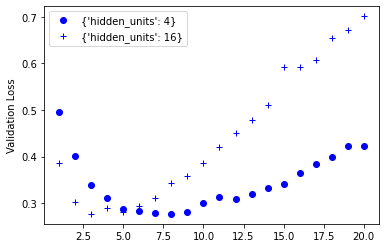

In [10]:
tests = [{'hidden_units': 4}, {'hidden_units': 16}]
execute_tests(tests)

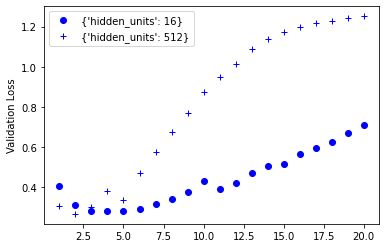

In [11]:
tests = [{'hidden_units': 16}, {'hidden_units': 512}]
execute_tests(tests)

### Add Weight Regularization
Force weights to take smaller values by imposing a cost.
- **L1 regularization**. Cost proportional to absolute value
- **L2 regularization, weight decay**. Cost proportional to square of value

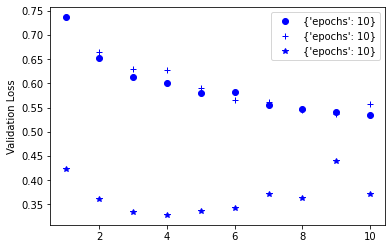

In [17]:
from keras import regularizers

tests = [{'regularizer': regularizers.l1(0.001)},
         {'regularizer': regularizers.l1(0.001)},
         {'regularizer': regularizers.l2(0.001)},
         {'regularizer': regularizers.l1_l2(0.001)}]
execute_tests(tests, ('bo', 'b+', 'b*'), epochs=10)

### Adding Dropout
Randomly set some number of output features to 0 during training. The dropout rate is the fraction of features zeroed out. Usually 0.2-0.5. Introducing noise to the output values can break up happenstance patters that aren't significant.

First method
1. Train with dropout
2. Test without dropout, but scale down each layer's output by dropout rate

Second method
1. Train with dropout and scale-up each layer's output during testing
2. Test normally

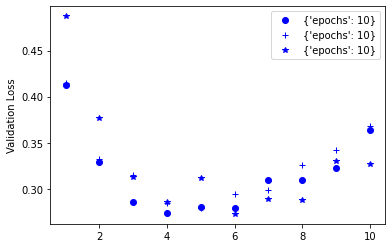

In [19]:
tests = [{}, {'dropout_rate': 0.2}, {'dropout_rate': 0.5}]
execute_tests(tests, ('bo', 'b+', 'b*'), epochs=10)

# Universal Workflow of Machine Learning

### 1. Define the problem and assemble a dataset
- What is your input data? What are you trying to predict?
- What type of problem is it: binary classification, multiclass classification, scalar regression, vector regression, multilabel multiclass classification?
The hypothesis at this stage:
1. Outputs can be predicted given inputs
2. Available data is sufficiently informative to learn how

### 2. Choose a measure of success
- Balanced classification problems (every class equally likely):
  - accuracy
  - area under the receiver operating characteristic curve (ROC AUC)
- Ranking Problems, multilabel classification:
  - average mean precision

### 3. Decide on an evaluation protocol
- Hold-out
- K-fold
- Iterated k-fold

### 4. Prepare data
- as tensors
- scale to [0, 1] or [-1, 1]
- normalize
- feature engineering

### 5. Develop a model that does better tahn a baseline
Three key choices:
1. Last-layer activation (sigmoid, softmax, none(regression))
2. Loss function (binary_crossentropy, categorical_crossentropy, mse)
3. Optimization configuration (normally 'rmsprop', default learning rate)

### 6. Develop a model that overfits
1. Add layers
2. Make the layers bigger
3. Train for more epochs

### 7. Regularize model, tune hyperparameters
- Add dropout
- Add or remove layers
- Add L1 and/or L2 regularization
- Try different hyperparameters: units per layer, learning rate
- Add new features, remove features

### 8. Fit with all traning data, Evaluate against test set